<a href="https://colab.research.google.com/github/eladvromen/Deep-Learning-Workshop/blob/main/wafer_segmenation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/NI_assigment/data/df_wafers.csv")
test = pd.read_csv("/content/drive/MyDrive/NI_assigment/data/df_wafers_test.csv")

##LDA

In [ ]:
data.head()

,WaferName,DieX,DieY,IsGoodDie,IsScratchDie
0,3b2e28,0,12,False,False
1,3b2e28,0,13,True,False
2,3b2e28,0,14,False,False
3,3b2e28,0,15,True,False
4,3b2e28,0,16,True,False


In [ ]:
data.shape

(16772092, 5)

In [ ]:
data["WaferName"].nunique()

3920

In [ ]:
data.isna().sum()

WaferName       0
DieX            0
DieY            0
IsGoodDie       0
IsScratchDie    0
dtype: int64

In [ ]:
data.dtypes

WaferName       object
DieX             int64
DieY             int64
IsGoodDie         bool
IsScratchDie      bool
dtype: object

In [ ]:
data.describe()

,DieX,DieY
count,1.677209e+07,1.677209e+07
mean,4.136554e+01,4.136554e+01
std,2.373912e+01,2.373912e+01
min,0.000000e+00,0.000000e+00
25%,2.200000e+01,2.200000e+01
50%,3.900000e+01,3.900000e+01
75%,5.900000e+01,5.900000e+01
max,1.040000e+02,1.040000e+02


In [ ]:
print(data["DieX"].quantile(0.95))
print(data["DieY"].quantile(0.95))
x_shape = data["DieX"].max()
y_shape = data["DieY"].max()

84.0
84.0


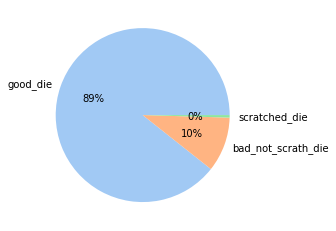

In [ ]:
#checking the categories distribution
good_die = data[(data["IsGoodDie"] ==True) & (data["IsScratchDie"]== False)]
inked_die = data[(data["IsGoodDie"] ==True) & (data["IsScratchDie"]==True)]
bad_not_scrath_die = data[(data["IsGoodDie"] ==False) & (data["IsScratchDie"]==False)]
bad_scratched_die = data[(data["IsGoodDie"] ==False) & (data["IsScratchDie"]==True)]
chart_data = [len(good_die),len(bad_not_scrath_die), len(inked_die)+ len(bad_scratched_die)]
labels = ['good_die','bad_not_scrath_die', 'scratched_die']
colors = sns.color_palette('pastel')[0:3]
plt.pie(chart_data, labels = labels, colors = colors, autopct='%.0000f%%')
plt.show()

In [ ]:
precent_of_scratch = data["IsScratchDie"].sum()/len(data)#including inked
print("precent of scratch die:" ,precent_of_scratch)



precent of scratch die: 0.004694524690181762


as we can see- the data is very unbalanced. 

we can infer that normal accuracy will do us no good in this model.

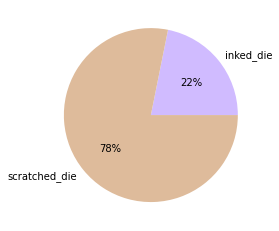

In [ ]:
#check the scratched data distribution
chart_2_data = [len(inked_die), len(bad_scratched_die)]
labels = ['inked_die','scratched_die']
colors = sns.color_palette('pastel')[4:6]
plt.pie(chart_2_data, labels = labels, colors = colors, autopct='%.0000f%%')
plt.show()

we want a label for is the die belongs to a scratched wafer or not

In [ ]:
Is_Scratched_wafer = data.groupby(["WaferName"])["IsScratchDie"].any().to_dict()


In [ ]:
IsScratched_to_WaferName = pd.DataFrame(list(Is_Scratched_wafer.items()), columns=["WaferName", "IsScratchedWafer"])
IsScratched_to_WaferName.set_index('WaferName')

,IsScratchedWafer
WaferName,
001f23,False
002e68,False
002ff9,False
003483,False
004531,False
...,...
ffa518,True
ffdb12,False
ffe0d2,False


In [ ]:
data['IsWaferScratch']= data['WaferName'].map(Is_Scratched_wafer)


In [ ]:
data["IsWaferScratch"].sum()/len(data)

0.5037071105977716

it is an intresting statistic- because we know that the data is balanced wafer wize. but we dont need this column in our data, so we will drop it.

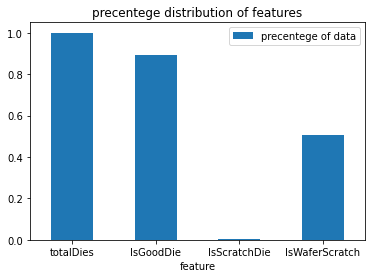

In [ ]:
df = pd.DataFrame({'feature':['totalDies','IsGoodDie', 'IsScratchDie', 'IsWaferScratch'], 'precentege of data':[len(data)/len(data),data["IsGoodDie"].sum()/len(data), data["IsScratchDie"].sum()/len(data), data["IsWaferScratch"].sum()/len(data)]})
df.plot.bar(title = "precentege distribution of features", x='feature', y='precentege of data', rot=0)

what we have learned from this is very important. 
we have several features of the data that we need to consider, before spliting to train and validation:
1. there is meaning to the dies belonging to certain wafer
2. the data is imbalanced regarding "IsScratchDie"

to split data by groups and to keep it stratified is a challenge.
however- we just saw that the wafer's themselves are distributed almost perfectly in half to scratched and none scratched.
therefor, when spliting dies grouped by mafer, we dont really need to worry about the imbalanced distribution of the "IsScratchDie", so we can use GroupShuffleSplit 

In [ ]:
from sklearn.model_selection import GroupShuffleSplit 

splitter = GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 7)
split = splitter.split(data, groups=data['WaferName'])

train_inds, test_inds = next(split)

train = data.iloc[train_inds]
validation = data.iloc[test_inds]

In [ ]:
train["WaferName"].nunique()

3136

In [ ]:
validation["WaferName"].nunique()

784

lets get a more visual understanding of the wafer maps:

In [ ]:
wafer_for_example = train[train['WaferName'] == '97a213']
wafer_for_example_no_scratch = train[train['WaferName'] == '001f23']


In [ ]:
def image_wafer(wafer_data, print = False):
  N = wafer_data["DieX"].max()+1
  M = wafer_data["DieY"].max()+1
  mat = np.zeros((M,N))
  for index, row in wafer_data.iterrows():
    if (row["IsScratchDie"]== True):
      if(row["IsGoodDie"] == False):#is scratch
           mat[row["DieX"], row["DieY"]] = 20
      if (row["IsGoodDie"] == True):#is inked
          mat[row["DieX"], row["DieY"]] = 10
    elif(row["IsScratchDie"]== False):
      if (row["IsGoodDie"] == True):#good 
         mat[row["DieX"], row["DieY"]] = 160
      if (row["IsGoodDie"] == True) :#bad 
         mat[row["DieX"], row["DieY"]] = 200
  if(print ==True):
    plt.imshow(mat, cmap = "RdYlGn", interpolation='nearest')
    plt.show()
  return mat

In [ ]:
def image_wafer_one_size(wafer_data,M,N, print = False):
  
  mat = np.zeros((M,N))
  for index, row in wafer_data.iterrows():
    if (row["IsScratchDie"]== True):
      if(row["IsGoodDie"] == False):#is scratch
           mat[row["DieX"], row["DieY"]] = 20
      if (row["IsGoodDie"] == True):#is inked
          mat[row["DieX"], row["DieY"]] = 10
    elif(row["IsScratchDie"]== False):
      if (row["IsGoodDie"] == True):#good 
         mat[row["DieX"], row["DieY"]] = 160
      if (row["IsGoodDie"] == True) :#bad 
         mat[row["DieX"], row["DieY"]] = 200
  if(print ==True):
    plt.imshow(mat, cmap = "RdYlGn", interpolation='nearest')
    plt.show()
  return mat

In [ ]:
def image_wafer_data(wafer_data, print =False):
  N = wafer_data["DieX"].max()+1
  M = wafer_data["DieY"].max()+1
  #print(N,M)
  mat = np.zeros((M,N))
  for index, row in wafer_data.iterrows():
    if row["IsGoodDie"] == False:#is bad
       mat[row["DieX"], row["DieY"]] = 150
    if row["IsGoodDie"] == True:#is good
      mat[row["DieX"], row["DieY"]] = 255
  
  if(print ==True):
    plt.imshow(mat, interpolation='nearest')
    plt.show()
  return mat

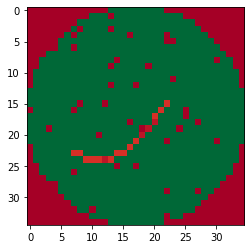

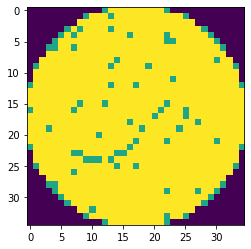

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
image_wafer(wafer_for_example, print = True)

image_wafer_data(wafer_for_example, print = True)

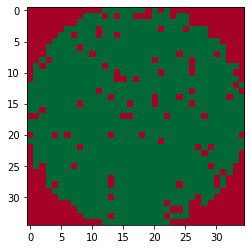

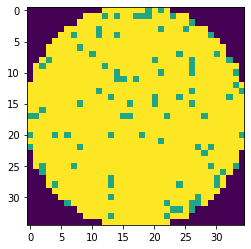

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:

image_wafer(wafer_for_example_no_scratch, print = True)
image_wafer_data(wafer_for_example_no_scratch, print = True)

lets split to target and data

In [ ]:
def target_split(data_Set):
  X = train.filter(items=['WaferName', 'DieX', 'DieY', 'IsGoodDie'])
  y = train["IsScratchDie"]
  return X, y

In [ ]:
X_train, y_train = target_split(train)
X_val, y_val = target_split(validation)

##1.xgboost
first, lets run a naive xgboosting model on the data, to see how it is preforming

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
best_grid_xgb = {
 'learning_rate': [0.2, 0.5],
 'max_depth': [4,8],
 'min_child_weight': [1,2],
 'subsample': [0.5, 0.7],
'colsample_bytree': [0.5, 1]
}

In [ ]:
def run_XGboost(x, y):
  xgb = XGBClassifier()
  tuned_xgb = GridSearchCV(estimator=xgb, 
                          param_grid=best_grid_xgb,
                          scoring='f1',
                          cv=3, 
                          verbose=3)
  tuned_xgb.fit(x, np.ravel(y))
  return tuned_xgb

In [ ]:
X_train.dtypes

WaferName    object
DieX          int64
DieY          int64
IsGoodDie      bool
dtype: object

In [ ]:
X_train_numeric = X_train.copy(deep = True)


In [ ]:
#!pip install category_encoders
#import category_encoders as ce

#encoder_waferName = ce.HashingEncoder(n_components=8, cols=['WaferName'])

#encoder_waferName.fit_transform(X_train_numeric)

ModuleNotFoundError: ignored

In [ ]:
from sklearn import preprocessing
def encoding():
  lbl = preprocessing.LabelEncoder()
  X_train_numeric = X_train.copy()
  X_val_numeric = X_val.copy()
  X_train_numeric['WaferName'] = lbl.fit_transform(X_train['WaferName'].astype(str))
  X_val_numeric['WaferName'] = lbl.fit_transform(X_val['WaferName'].astype(str))
  pass

in here, all the "nice" ways to encode categorial label has failed. 
the enable_categorial built in option didnt work(i think because of too many labels). the labelencoder created a very slow and heavy data to run. so the main solution that i have left is properly one-hot-encode the "wafername" to 3500+ different dummie variables.

this seems of. it leads me to believe that the tabular representation is not best suited to the task.

In [ ]:
def run_XGboost(x_train, x_test):
  trained_xgboost = run_XGboost(X_train_numeric, y_train)
  trained_xgboost.best_params_
  trained_xgboost.best_score_
  pass
  

In [ ]:
#trained_xgboost.save_model("/content/drive/MyDrive/NI_assigment/data/best_params.json")

##2. CNN
lets try to run a cnn on the data. since scratches has geometric meaning, i believe a better classifier can be trained on a matrix representation of the data. so lets create it first.

In [ ]:
def get_wafer_names(data_set):
  names = data_set["WaferName"].unique()
  return names

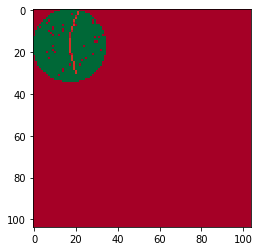

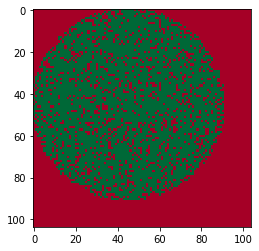

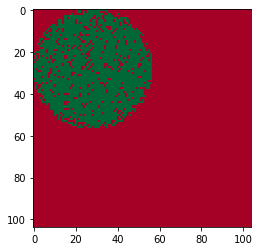

In [ ]:
for wafer in IsScratched_to_WaferName.iloc[[1400,456,12],0]:
  wafer_for_example_ = data[data['WaferName'] == wafer]
  image_wafer_one_size(wafer_for_example_,x_shape,y_shape, print = True)



we can see that different wafers have different size. this may be problematic for a cnn.

i think that evem though this is a problem, the data and the assigment is still an image segmentation problem in its assence.

we have too many advanteges when representing the data as images-
1. the geometric meaning of scratches is clearly represented.
2. the categorial character of the wafer name becomes the picture object it self, instead of 3,500+ dummie variables
3. creating new data for training is very easy and coherent when using image augmentation.

therefor, i will try to solve the problem of reshaping. there are 2 main ways i can think of: 
1. reshape the data
2. use FCN

i think that the first step would be to use ordinary reshaping, to see how the model preforms. 

###create_dict data

In [ ]:
def mask_label(wafer_data, print =False):
  N = wafer_data["DieX"].max()+1
  M = wafer_data["DieY"].max()+1
  mat = np.zeros((M,N))
  for index, row in wafer_data.iterrows():
    if row["IsScratchDie"] == False:#is bad
       mat[row["DieX"], row["DieY"]] = 1
    if row["IsScratchDie"] == True:#is good
      mat[row["DieX"], row["DieY"]] = 2
  
  if(print ==True):
    plt.imshow(mat, interpolation='nearest')
    plt.show()
  return mat

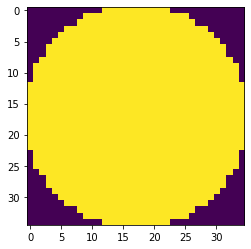

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
image_wafer_data(wafer_for_example_no_scratch, print = True)
mask_label(wafer_for_example_no_scratch, print = True)

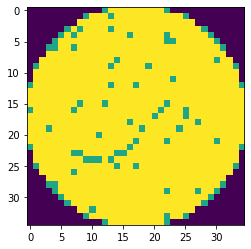

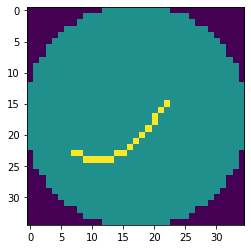

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
image_wafer_data(wafer_for_example, print = True)
mask_label(wafer_for_example, print = True)


In [ ]:
def create_image_data(table_data):
  wafer_dict = {}
  wafer_label_dict = {}
  wafer_binary_label_dict = {}
  wafer_names = get_wafer_names(table_data)

  for wafer in wafer_names:
    curr_wafer = table_data[table_data['WaferName'] == wafer]
    wafer_dict["{0}".format(wafer)] = image_wafer_data(curr_wafer)
    wafer_label_dict["{0}".format(wafer)] = mask_label(curr_wafer)
    wafer_binary_label_dict["{0}".format(wafer)]= IsScratched_to_WaferName.loc[IsScratched_to_WaferName['WaferName'] == wafer, 'IsScratchedWafer'].iloc[0]

  return wafer_dict, wafer_label_dict, wafer_binary_label_dict

In [ ]:
def create_image_test(table_data):
  wafer_dict = {}
  
  wafer_names = get_wafer_names(table_data)

  for wafer in wafer_names:
    curr_wafer = table_data[table_data['WaferName'] == wafer]
    wafer_dict["{0}".format(wafer)] = image_wafer_data(curr_wafer)
    
  return wafer_dict

In [ ]:
#wafer_dict_train, wafer_label_dict_train, binary_dict_train = create_image_data(train)
wafer_dict_test = create_image_test(test)

In [ ]:
len(wafer_dict_test)

439

In [ ]:
def save_dicts_train(wafer_dict, wafer_label_dict, wafer_binary_label_dict) 
# save dictionary to pickle file
  with open('/content/drive/MyDrive/NI_assigment/data/wafer_dict_train.pickle', 'wb') as file:
      pickle.dump(wafer_dict_train, file, protocol=pickle.HIGHEST_PROTOCOL)
  with open('/content/drive/MyDrive/NI_assigment/data/wafer_label_dict_train.pickle', 'wb') as file:
      pickle.dump(wafer_label_dict_train, file, protocol=pickle.HIGHEST_PROTOCOL)
  with open('/content/drive/MyDrive/NI_assigment/data/wafer_binary_train.pickle', 'wb') as file:
      pickle.dump(binary_dict_train, file, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
  with open('/content/drive/MyDrive/NI_assigment/data/wafer_dict_test.pickle', 'wb') as file:
      pickle.dump(wafer_dict_test, file, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#wafer_dict_val, wafer_label_dict_val, binary_dict_val = create_image_data(validation)

In [ ]:
def save_dicts_train(wafer_dict_val, wafer_label_dict_val, binary_dict_val) 
# save dictionary to pickle file
  with open('/content/drive/MyDrive/NI_assigment/data/wafer_dict_val.pickle', 'wb') as file:
      pickle.dump(wafer_dict_val, file, protocol=pickle.HIGHEST_PROTOCOL)
  with open('/content/drive/MyDrive/NI_assigment/data/wafer_label_dict_val.pickle', 'wb') as file:
      pickle.dump(wafer_label_dict_val, file, protocol=pickle.HIGHEST_PROTOCOL)
  with open('/content/drive/MyDrive/NI_assigment/data/wafer_binary_val.pickle', 'wb') as file:
      pickle.dump(binary_dict_val, file, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
wafer_dict['2cd2b6'].sum()

###load dict data

In [ ]:
with open('/content/drive/MyDrive/NI_assigment/data/wafer_dict_train.pickle', "rb") as file:
    wafer_dict_train = pickle.load(file)
with open('/content/drive/MyDrive/NI_assigment/data/wafer_label_dict_train.pickle', "rb") as file:
    label_dict_train = pickle.load(file)
with open('/content/drive/MyDrive/NI_assigment/data/wafer_binary_train.pickle', "rb") as file:
    binary_label_train = pickle.load(file)
with open('/content/drive/MyDrive/NI_assigment/data/wafer_dict_val.pickle', 'rb') as file:
    wafer_dict_val = pickle.load(file)
with open('/content/drive/MyDrive/NI_assigment/data/wafer_label_dict_val.pickle', 'rb') as file:
    label_dict_val = pickle.load(file)
with open('/content/drive/MyDrive/NI_assigment/data/wafer_binary_val.pickle', "rb") as file:
    binary_label_val = pickle.load(file)
with open('/content/drive/MyDrive/NI_assigment/data/wafer_dict_test.pickle', 'rb') as file:
    wafer_dict_test = pickle.load(file)


In [ ]:
def mat_wafer_print(wafer):
 
  plt.imshow(wafer, cmap = "RdYlGn", interpolation='nearest')
  plt.show()


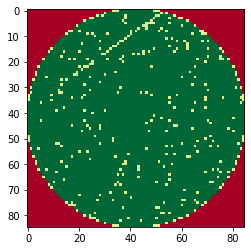

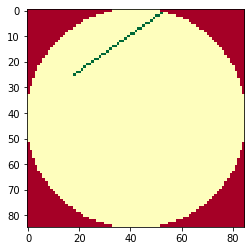

In [ ]:
mat_wafer_print(wafer_dict_train["d412db"])
mat_wafer_print(label_dict_train["d412db"])

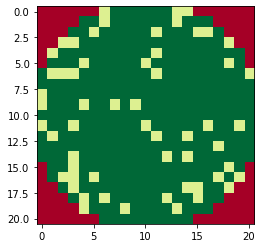

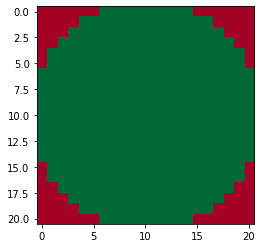

In [ ]:
mat_wafer_print(wafer_dict_val["acf4db"])
mat_wafer_print(label_dict_val["acf4db"])

In [ ]:
#for the final training
def Merge(dict1, dict2):
    res = {**dict1, **dict2}
    return res
full_wafer_dict= Merge(wafer_dict_train, wafer_dict_val)
full_label_dict= Merge(label_dict_train, label_dict_val)

###create tensor data

if we want to train a cnn on the data, we need to resize the data

In [ ]:
import tensorflow as tf

In [ ]:
# Convert the dictionaries to lists of tuples
def dict_to_model_format(dict_data, dict_label):
  data = list(zip(dict_data.values(), dict_label.values()))

  # Find the maximum height and width among all images and labels
  #height = max([image.shape[0] for image, _ in data])
  #width = max([image.shape[1] for image, _ in data])
  height = 128
  width = 128
  # Pad the images and labels to the maximum height and width
  padded_im = []
  padded_labels = []
  for image, label in data:
    image = tf.expand_dims(image, axis=-1)
    label = tf.expand_dims(label, axis=-1)
    padded_image = tf.image.resize_with_crop_or_pad(image, height, width)
    padded_label = tf.image.resize_with_crop_or_pad(label, height, width)
    #lets also normalize:
 
    padded_image = padded_image/255
    
    padded_im.append(padded_image)
    padded_labels.append(padded_label)

  # Create a tf.data.Dataset object from the list of tuples
  print(padded_im[0].shape)
  
  images_dataset = tf.data.Dataset.from_tensor_slices(padded_im)
  labels_dataset = tf.data.Dataset.from_tensor_slices(padded_labels)
  ds = tf.data.Dataset.zip((images_dataset, labels_dataset))
  
  return ds
  #return images_dataset, labels_dataset

In [ ]:
def dict_to_model_format_test(dict_data):
  data = list(dict_data.values())


  height = 128
  width = 128
  # Pad the images and labels to the maximum height and width
  padded_im = []

  for image in data:
    image = tf.expand_dims(image, axis=-1)

    padded_image = tf.image.resize_with_crop_or_pad(image, height, width)
   
    #lets also normalize:
 
    padded_image = padded_image/255
    
    padded_im.append(padded_image)
  
  
  images_dataset = tf.data.Dataset.from_tensor_slices(padded_im)

  return images_dataset

In [ ]:
def dict_to_model_format_parts(dict_data, dict_label, binary_dict):
  data = list(zip(dict_data.values(), dict_label.values()))
  class_labels = binary_dict.values()
  # Find the maximum height and width among all images and labels
  #height = max([image.shape[0] for image, _ in data])
  #width = max([image.shape[1] for image, _ in data])
  height = 128
  width = 128
  # Pad the images and labels to the maximum height and width
  padded_im = []
  padded_labels = []
  for image, label in data:
    image = tf.expand_dims(image, axis=-1)
    label = tf.expand_dims(label, axis=-1)
    padded_image = tf.image.resize_with_crop_or_pad(image, height, width)
    padded_label = tf.image.resize_with_crop_or_pad(label, height, width)
    #lets also normalize:
 
    padded_image = padded_image/255
    
    padded_im.append(padded_image)
    padded_labels.append(padded_label)

  # Create a tf.data.Dataset object from the list of tuples
  print(padded_im[0].shape)
  images_dataset = tf.data.Dataset.from_tensor_slices(padded_im)
  labels_dataset = tf.data.Dataset.from_tensor_slices(padded_labels)
  #ds = tf.data.Dataset.zip((images_dataset, labels_dataset))
  #return ds
  return images_dataset, labels_dataset, binary_dict

lets make sure the data is good

In [ ]:
def check_tensor_data(dataset):
  # Retrieve a small slice of the dataset
  small_slice = dataset.take(3)

  # Set up the subplots
  fig, axs = plt.subplots(3, 2, figsize=(10, 20))

  # Iterate over the small slice
  for i, (image_batch, label_batch) in enumerate(small_slice):
    image_batch = np.squeeze(image_batch)  # convert 3D image to 2D
    label_batch = np.squeeze(label_batch)
    # Display the original image
    axs[i, 0].imshow(image_batch)
    axs[i, 0].set_title("Original Image")
    
    # Display the label image
    axs[i, 1].imshow(label_batch)
    axs[i, 1].set_title("Label Image")

  plt.show()




In [ ]:
train_dataset = dict_to_model_format(wafer_dict_train, label_dict_train)
validation_dataset = dict_to_model_format(wafer_dict_val, label_dict_val)
test_dataset = dict_to_model_format_test(wafer_dict_test)
full_train_dataset = dict_to_model_format(full_wafer_dict,full_label_dict)

(128, 128, 1)
(128, 128, 1)
(128, 128, 1)


In [ ]:
#train_dataset = dict_to_model_format_listversion(wafer_dict_train, label_dict_train)
#validation_dataset = dict_to_model_format_listversion(wafer_dict_val, label_dict_val)

In [ ]:
print(train_dataset.element_spec)

(TensorSpec(shape=(128, 128, 1), dtype=tf.float64, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.float64, name=None))


In [ ]:
#train_image, train_mask, binary_train = dict_to_model_format_parts(wafer_dict_train, label_dict_train, binary_label_train)
#val_image, val_mask, binary_val = dict_to_model_format_parts(wafer_dict_val, label_dict_val, binary_label_val)

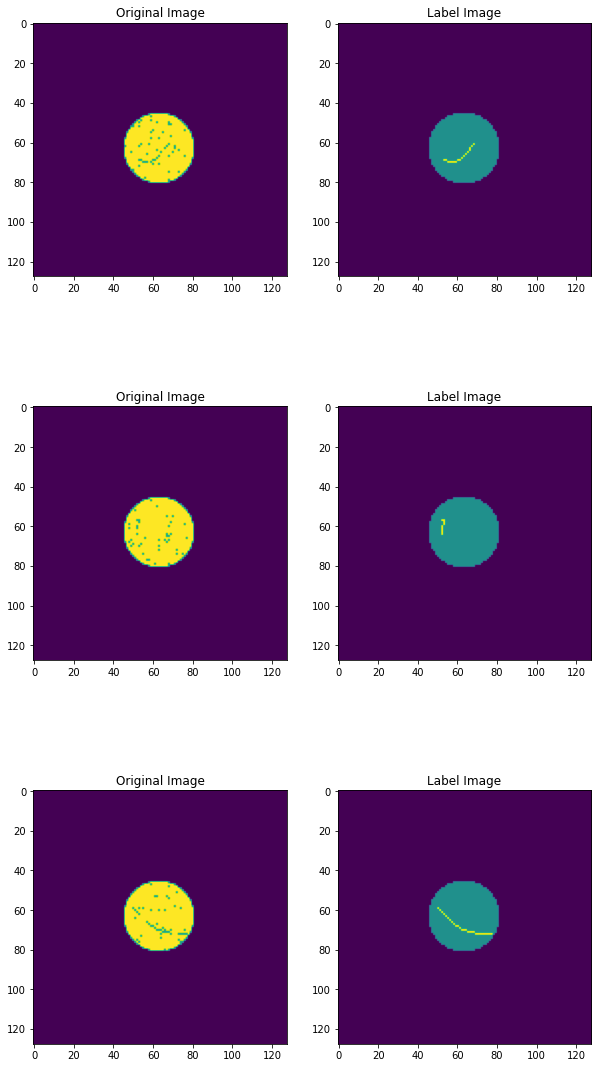

In [ ]:
check_tensor_data(train_dataset)

###data augmentation

In [ ]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [ ]:
augmented_train_ds = train_ds.map(Augment())

In [ ]:
type(augmented_train_ds)

In [ ]:
check_tensor_data(augmented_train_ds)


##models

In [ ]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

###Unet

unfortunetly, with in the deadline, i was not able to make the Unet work. it seems that theres somthing off with the dimensions- the prediction returns a too small segmentation mash (128,16,1).
for this reason, also the NN it self does not improve between epochs. 



In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

    #jaccard distance is a good metric for images similarity- so it can be a proper loss function for us.
def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac
def jaccard_loss(y_true, y_pred, smooth=100):
    jac = jaccard_distance(y_true, y_pred, smooth=100)
    return (1 - jac) * smooth

In [ ]:
from tensorflow.keras import layers
def get_model(img_size, num_classes):
    inputs = layers.Input(shape=img_size+(1,))
    #initializer = tf.keras.initializers.LecunNormal()
    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.LeakyReLU(alpha=0.01)(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.LeakyReLU(alpha=0.01)(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = tf.keras.Model(inputs, outputs)
    return model

In [ ]:
model = get_model((128,128), 1)

In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_36 (Conv2D)             (None, 64, 64, 32)   320         ['input_5[0][0]']                
                                                                                                  
 batch_normalization_60 (BatchN  (None, 64, 64, 32)  128         ['conv2d_36[0][0]']              
 ormalization)                                                                                    
                                                                                            

In [ ]:
EPOCHS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
#model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy', f1_m, recall_m, precision_m])
opt = tf.keras.optimizers.Adam(learning_rate = 0.3)
model.compile(optimizer=opt, loss=jaccard_loss, metrics=[jaccard_distance])
train_dataset.batch(BATCH_SIZE)
train_ds = train_dataset.cache().shuffle(BUFFER_SIZE)
model_history = model.fit(train_ds, epochs=EPOCHS, validation_data=validation_dataset, batch_size=32)




Epoch 1/5


3136/3136 [==============================] - ETA: 0s - loss: 10.1636 - jaccard_distance: 0.8984

3136/3136 [==============================] - 145s 45ms/step - loss: 10.1636 - jaccard_distance: 0.8984 - val_loss: 10.2165 - val_jaccard_distance: 0.8978
Epoch 2/5
3136/3136 [==============================] - 141s 45ms/step - loss: 10.1636 - jaccard_distance: 0.8984 - val_loss: 10.2165 - val_jaccard_distance: 0.8978
Epoch 3/5
3136/3136 [==============================] - 141s 45ms/step - loss: 10.1636 - jaccard_distance: 0.8984 - val_loss: 10.2165 - val_jaccard_distance: 0.8978
Epoch 4/5
3136/3136 [==============================] - 141s 45ms/step - loss: 10.1636 - jaccard_distance: 0.8984 - val_loss: 10.2165 - val_jaccard_distance: 0.8978
Epoch 5/5
3136/3136 [==============================] - 140s 45ms/step - loss: 10.1636 - jaccard_distance: 0.8984 - val_loss: 10.2165 - val_jaccard_distance: 0.8978


In [ ]:
model.save('/content/drive/MyDrive/NI_assigment/data/simple_unet')

In [ ]:
model.evaluate

In [ ]:
pred_model = model.predict(test_dataset, verbose=1, batch_size=64)

439/439 [==============================] - 7s 14ms/step


In [ ]:
pred_model[3].shape

(128, 16, 1)

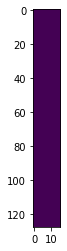

In [ ]:
plt.imshow(tf.argmax(pred_model[0], axis=-1).numpy())

In [ ]:
pred_model_class = tf.argmax(pred_model, axis=-1).numpy()

In [ ]:
num_samples_to_show = 3
test_samples_to_show = list(test_dataset.take(num_samples_to_show))

In [ ]:

def show_predictions(y_pred):
  fig, axes = plt.subplots(num_samples_to_show, 3, figsize=(36, 12))
  if num_samples_to_show == 1:
    i = 0
    axes[0].imshow(test_samples_to_show[i][0][0, :, :, :] / 255., aspect="auto")
    axes[0].set_axis_off()
    axes[0].set_title('Original image')

    axes[1].imshow(test_samples_to_show[i][1][0, :, :], aspect="auto")
    axes[1].set_axis_off()
    axes[1].set_title('Ground truth')

    axes[2].imshow(y_pred[i, :, :], aspect="auto")
    axes[2].set_axis_off()
    axes[2].set_title('Predicted mask')
    return 1

  for i in range(num_samples_to_show):
    axes[i, 0].imshow(test_samples_to_show[i][0][0, :, :, :] / 255., aspect="auto")
    axes[i, 0].set_axis_off()
    axes[i, 0].set_title('Original image')

    axes[i, 1].imshow(test_samples_to_show[i][1][0, :, :], aspect="auto")
    axes[i, 1].set_axis_off()
    axes[i, 1].set_title('Ground truth')

    axes[i, 2].imshow(y_pred[i, :, :], aspect="auto")
    axes[i, 2].set_axis_off()
    axes[i, 2].set_title('Predicted mask')

InvalidArgumentError: ignored

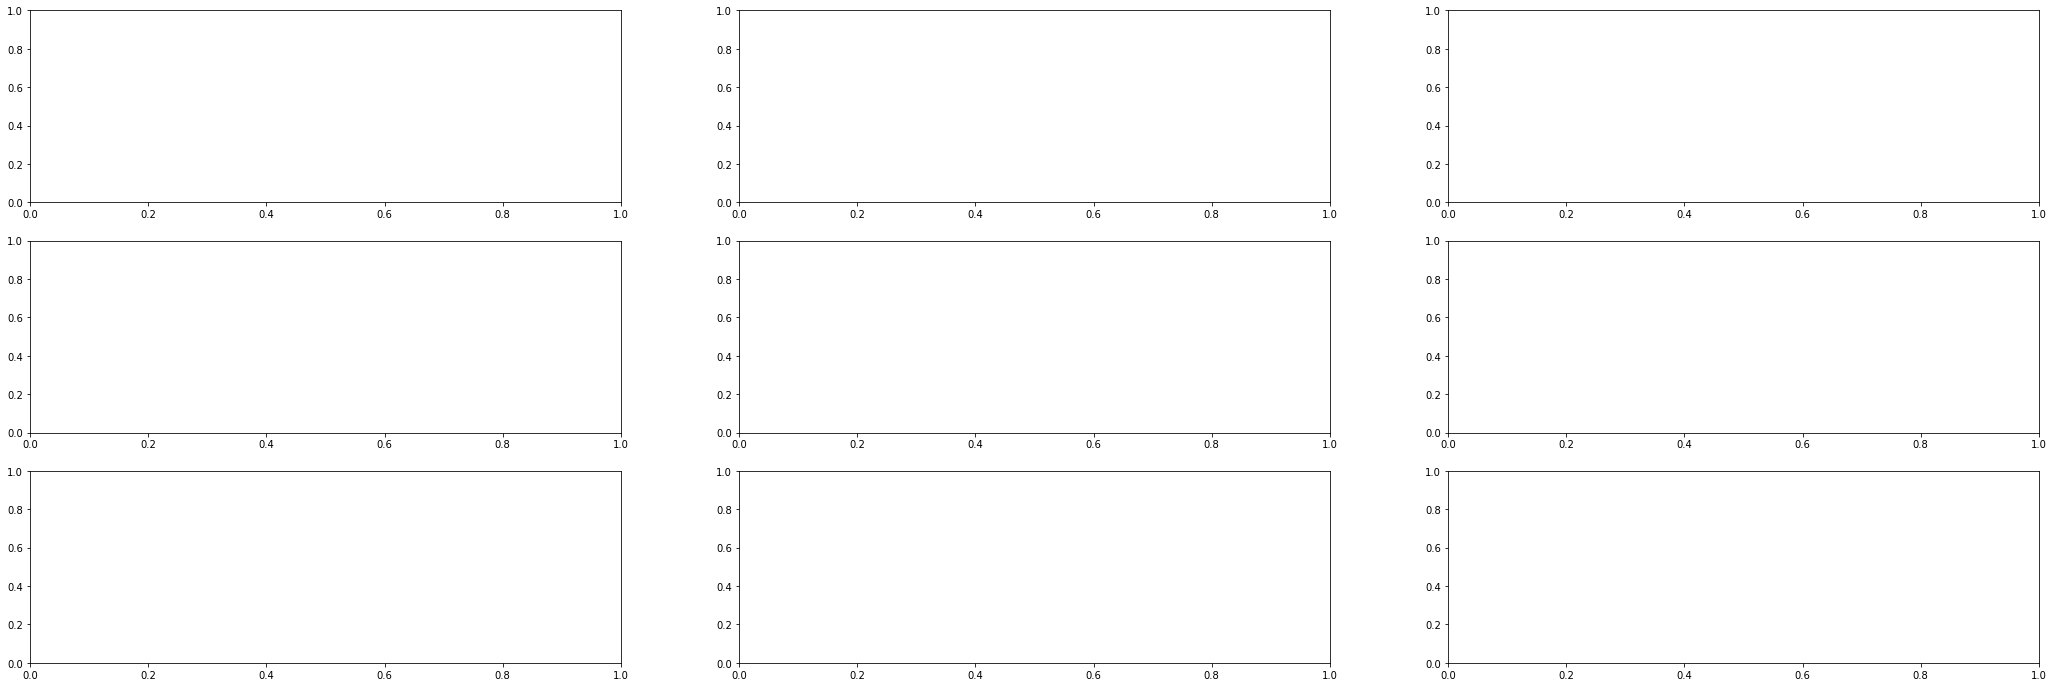

In [ ]:
show_predictions(pred_model_class)